# Prerequisites

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [2]:
batch_size = 32
img_height = 180
img_width = 180

# Import Dataset 

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='drive/MyDrive/new_dataset/',
  labels='inferred',
  label_mode='binary',
  class_names=['insulators','non_insulators'],
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 315 files belonging to 2 classes.
Using 252 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='drive/MyDrive/new_dataset/',
  labels='inferred',
  label_mode='binary',
  class_names=['insulators','non_insulators'],
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 315 files belonging to 2 classes.
Using 63 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['insulators', 'non_insulators']


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 1)


# Dataset Optimization

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.009129553 1.0


# Model Creation

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Training Model 

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
8/8 [==============================] - 19s 511ms/step - loss: 1.0160 - accuracy: 0.5437 - val_loss: 0.6499 - val_accuracy: 0.6190
Epoch 2/10
8/8 [==============================] - 0s 30ms/step - loss: 0.5833 - accuracy: 0.7143 - val_loss: 0.5126 - val_accuracy: 0.9365
Epoch 3/10
8/8 [==============================] - 0s 26ms/step - loss: 0.3133 - accuracy: 0.9603 - val_loss: 0.2147 - val_accuracy: 0.9683
Epoch 4/10
8/8 [==============================] - 0s 28ms/step - loss: 0.1157 - accuracy: 0.9643 - val_loss: 0.1522 - val_accuracy: 0.9365
Epoch 5/10
8/8 [==============================] - 0s 25ms/step - loss: 0.0421 - accuracy: 0.9960 - val_loss: 0.1032 - val_accuracy: 0.9524
Epoch 6/10
8/8 [==============================] - 0s 26ms/step - loss: 0.0229 - accuracy: 0.9921 - val_loss: 0.1452 - val_accuracy: 0.9524
Epoch 7/10
8/8 [==============================] - 0s 27ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.0793 - val_accuracy: 0.9524
Epoch 8/10
8/8 [=========

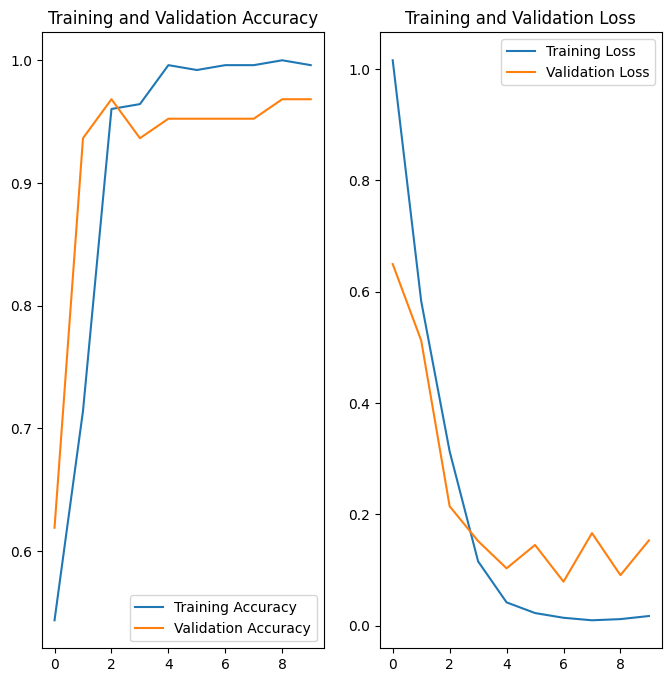

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data Augmentation

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

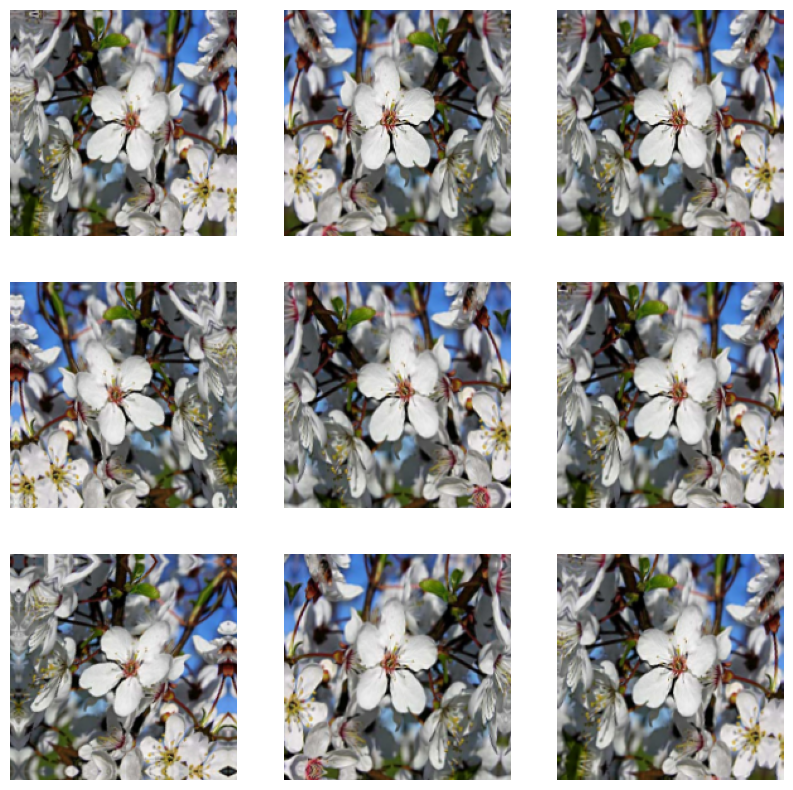

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Re-Training with Augmented Data

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [21]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
8/8 [==============================] - 3s 76ms/step - loss: 1.2258 - accuracy: 0.4921 - val_loss: 0.6720 - val_accuracy: 0.6032
Epoch 2/15
8/8 [==============================] - 0s 37ms/step - loss: 0.6481 - accuracy: 0.5635 - val_loss: 0.6489 - val_accuracy: 0.3968
Epoch 3/15
8/8 [==============================] - 0s 35ms/step - loss: 0.5119 - accuracy: 0.7024 - val_loss: 0.4628 - val_accuracy: 0.8889
Epoch 4/15
8/8 [==============================] - 0s 35ms/step - loss: 0.2769 - accuracy: 0.9524 - val_loss: 0.2445 - val_accuracy: 0.9048
Epoch 5/15
8/8 [==============================] - 0s 34ms/step - loss: 0.1197 - accuracy: 0.9563 - val_loss: 0.1353 - val_accuracy: 0.9206
Epoch 6/15
8/8 [==============================] - 0s 35ms/step - loss: 0.0829 - accuracy: 0.9802 - val_loss: 0.0708 - val_accuracy: 0.9683
Epoch 7/15
8/8 [==============================] - 0s 34ms/step - loss: 0.0626 - accuracy: 0.9802 - val_loss: 0.0823 - val_accuracy: 0.9683
Epoch 8/15
8/8 [===========

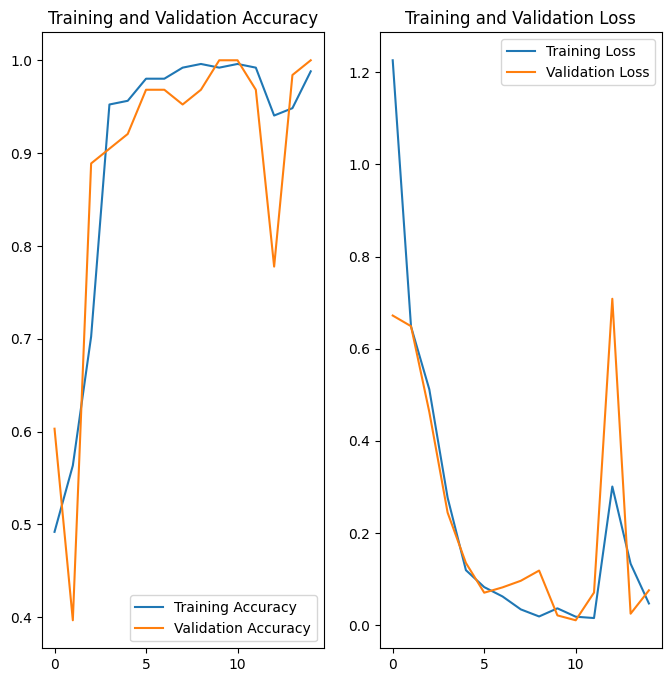

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on new Data

In [24]:
sunflower_url = "https://cdn.globalso.com/johnsoninsulator/222222.jpg"
sunflower_path = tf.keras.utils.get_file('Insulator', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to non_insulators with a 100.00 percent confidence.
